# distance_dist

In [37]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [38]:
exp_name = 'distance_dist'

In [39]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import itertools
from tqdm import tqdm
from scipy.spatial.distance import canberra
from sklearn.neighbors import KNeighborsRegressor
import multiprocessing
import Levenshtein
import difflib
import pickle
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [40]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    os.makedirs(OUTPUT_DIR + 'prep/' + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'

In [41]:
# CONFIG
SEED = 42
N_NEIGHBORS = 10
N_SPLITS = 5
PROB_TH = 0.5

In [42]:
train = pd.read_csv(INPUT_DIR + "train.csv")

(array([5.2127e+04, 1.5600e+02, 6.6000e+01, 4.0000e+01, 3.0000e+01,
        2.0000e+01, 2.1000e+01, 1.2000e+01, 6.0000e+00, 1.1000e+01,
        1.0000e+01, 9.0000e+00, 5.0000e+00, 9.0000e+00, 4.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 4.0000e+00, 8.0000e+00,
        2.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

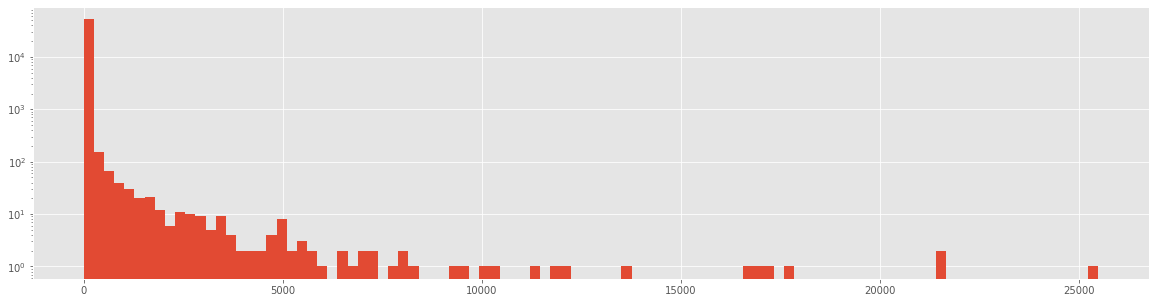

In [43]:
fig, ax = plt.subplots(figsize=(20,5))
ax.hist(train['categories'].value_counts(), log=True, bins=100)

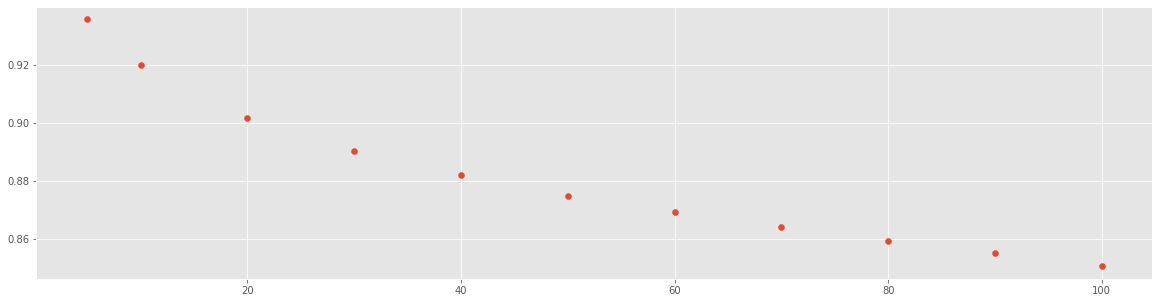

In [44]:
# カウント数の足切り検討
vc = train['categories'].value_counts().to_frame()

ths = [5, 10,20,30,40,50,60,70,80,90,100]
rates = []
for th in ths:
    rate = vc[vc['categories']>th]['categories'].sum() / vc['categories'].sum()
    rates.append(rate)

fig, ax = plt.subplots(figsize=(20,5))
ax.scatter(ths, rates)

In [45]:
def extract_candidate(df):
    dfs = []
    candidates = pd.DataFrame()
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), 10), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        
        k = min(len(country_df), 10)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df['d_near'] = dists[:, :k].tolist()
        dfs.append(country_df[['id','match_id','d_near']])
    df = pd.concat(dfs).reset_index(drop=True)
    return df

# 距離算出が一致しているか事前確認

In [46]:
knn_result = extract_candidate(train.head(1000))
knn_result = knn_result.explode(['match_id','d_near'])

100%|██████████| 68/68 [00:00<00:00, 70.29it/s]


In [47]:
knn_result

,id,match_id,d_near
0,E_0013149ad8ed18,E_0013149ad8ed18,0.0
0,E_0013149ad8ed18,E_0030de94b528e7,0.07938
0,E_0013149ad8ed18,E_0031c764c706c6,0.237002
0,E_0013149ad8ed18,E_002e4c4793fbc7,0.783273
0,E_0013149ad8ed18,E_0019ce8998b3a8,0.917119
...,...,...,...
997,E_001750bd8a2e4e,E_001750bd8a2e4e,0.0
998,E_0003ffef645c7f,E_0003ffef645c7f,0.0
998,E_0003ffef645c7f,E_000695824236ae,0.528505
999,E_000695824236ae,E_000695824236ae,0.0


In [48]:
tmp = train[train['id'].isin(['E_0013149ad8ed18', 'E_0031c764c706c6'])]
haversine_distances(tmp[["latitude", "longitude"]].values)

array([[0.       , 0.2370018],
       [0.2370018, 0.       ]])

一致する

# 距離計算
https://www.kaggle.com/code/hidehisaarai1213/foursquare-eda-distance-distribution-variation/notebook

In [50]:
poi2distances = {}
for poi, df in tqdm(train[["latitude", "longitude", "point_of_interest"]].groupby("point_of_interest"),
                    total=train["point_of_interest"].nunique()):
    if len(df) == 1:
        # no matches
        continue
        
    distances = []
    distances_mat = haversine_distances(df[["latitude", "longitude"]].values)
    for i in range(len(df)):
        for j in range(len(df)):
            if j >= i:
                continue
            # haversine distance -> meters
            distances.append(distances_mat[i, j])
    poi2distances[poi] = distances

100%|██████████| 739972/739972 [01:29<00:00, 8242.84it/s]


In [51]:
poi2distances_df = pd.DataFrame({
    "point_of_interest": list(poi2distances.keys()),
    "distances": list(poi2distances.values())
})
poi2distances_df.head()

,point_of_interest,distances
0,P_00001c309a5e0a,"[7.392899610072019e-05, 0.0013074433813009816,..."
1,P_0000561fe92bed,[0.0005504564134837164]
2,P_0000bccb92573c,[7.01213571512607e-05]
3,P_0000c58a53df6d,[0.002288377953984225]
4,P_00010455487fcf,[0.0004857766987403706]


In [52]:
train["categories"] = train["categories"].fillna("").map(lambda x: x.split(", "))
train_ = train[["id", "name", "categories", "point_of_interest"]].merge(
    poi2distances_df, on="point_of_interest", how="inner")

In [53]:
exploded = train_.explode('categories').explode('distances')
exploded = exploded.drop_duplicates(['categories', 'point_of_interest', 'distances'])
exploded.head()

,id,name,categories,point_of_interest,distances
0,E_000001272c6c5d,Café Stad Oudenaarde,Bars,P_677e840bb6fc7e,0.00942
2,E_000002eae2a589,Carioca Manero,Brazilian Restaurants,P_d82910d8382a83,0.000227
3,E_e80db432029aea,Carioca Manero,Bars,P_d82910d8382a83,0.000227
3,E_e80db432029aea,Carioca Manero,Snack Places,P_d82910d8382a83,0.000227
4,E_00001d92066153,Restaurante Casa Cofiño,Spanish Restaurants,P_809a884d4407fb,0.000106


In [54]:
def percentile25(x):
    return np.percentile(x, q=25)
def percentile75(x):
    return np.percentile(x, q=75)
def percentile90(x):
    return np.percentile(x, q=90)
def percentile95(x):
    return np.percentile(x, q=95)


aggregated_df = exploded.groupby("categories").agg({
    "distances": ["max", "min", "mean", "median", "std", 
                  percentile25, percentile75, percentile90, percentile95],
    "id": "count"
})

aggregated_df.head()

distances                                          \
                           max       min      mean    median       std   
categories                                                               
                      3.139476  0.000000  0.328330  0.030052  0.627895   
ATMs                  3.059347  0.000000  0.113454  0.001559  0.388037   
Acai Houses           0.021202  0.000003  0.002201  0.000960  0.004197   
Accessories Stores    2.908691  0.000000  0.190494  0.002465  0.521948   
Acehnese Restaurants  0.075329  0.000023  0.018210  0.014562  0.017227   

                                                                          \
                     percentile25 percentile75 percentile90 percentile95   
categories                                                                 
                         0.002708     0.211639     1.371936     1.870677   
ATMs                     0.000378     0.011669     0.147516     0.863028   
Acai Houses              0.000178     0.002147     0.004925     0.006026   
Accessories Stores       0.000469     0.050477     0.583247     1.711482   
Acehnese Restaurants     0.003227     0.028496     0.042701     0.050414   

                          id  
                       count  
categories                    
                      542100  
ATMs                    2690  
Acai Houses               27  
Accessories Stores      1868  
Acehnese Restaurants     153

In [58]:
aggregated_df.columns = ['max', 'min', 'mean', 'median', 'std',
                         'percentile25', 'percentile75', 'percentile90', 'percentile95', 'count']

In [63]:
aggregated_df.to_csv(OUTPUT_DIR + 'prep/' + exp_name + '/distance_dist.csv')